In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from scipy.stats import norm
from itertools import combinations, permutations, product

from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def sample_sigmoid(time_range, n=1, change_rate=0.5):
    x = np.arange(time_range)
    mid = int(time_range / 2)
    y = (1 / (1 + np.exp(-0.1* (x-mid) ))) * n * change_rate
    y = (y - y.min()) / (y.max() - y.min())
    
    y = n + y * n * change_rate
    
    print(y)
    plt.figure(figsize=(20, 5))
    plt.plot(x, y)
    plt.show()
    
def sample_bell(time_range, n=1, change_rate=0.5, std=0):
    x = np.arange(time_range)
    mu = int(time_range / 2)
    std = std if std else int(time_range / 5)
    y = norm.pdf(x, mu, std)
    # scale 0-1
    y_min = y.min()
    y_max = y.max()
    y = (y - y_min) / (y_max - y_min)
    # add n docs
    y = n + y * n * change_rate
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y)
    plt.show()
    

def sample_linear(time_range, n=100, change_rate=0.5):
    x = np.arange(time_range)
    y = (x - x.min()) / (x.max() - x.min())
    y = n + y * n * change_rate
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y)
    plt.show()

In [3]:
def linear_pattern(n=1, start=0, stop=100, change_rate=1):
    """
    Sampling up pattern, start and end in random points
    """
    # print(lower_p, upper_p)
    # change_points = np.array([0, lower_p, upper_p, timeline], dtype=int)
    x = np.arange(start, stop)
    # normalize x to range 0-1
    y = (x - start) / (stop - start)
    freq_rates = n + y * n * change_rate
    
    return freq_rates

def sigmoid_pattern(n=1, start=0, stop=100, change_rate=1):
    x = np.arange(start, stop)
    mid = int((stop - start) / 2)
    y = 1 / (1 + np.exp(-0.1* (x-mid) ))
    y = (y - y.min()) / (y.max() - y.min())
    
    freq_rates = n + y * n * change_rate
    return freq_rates

def flat_pattern(n=1, start=0, stop=100):
    freq_rates = np.ones(stop-start) * n
    return freq_rates


def bell_pattern(n=1, start=0, stop=100, change_rate=1, std=0):
    sample_list = []
    time_range = stop - start
    
    x = np.arange(start, stop)
    mu = int(time_range / 2)
    
    std = std if std else int(time_range / 5)
    y = norm.pdf(np.arange(time_range), mu, std)
    # scale 0-1
    y = (y - y.min()) / (y.max() - y.min())
    # add n docs
    freq_rates = n + y * n * change_rate
    
    return freq_rates


def sample_pattern(pattern, timeline=100, change_rate=0.01):
    sample = None
    
    if pattern == 'up':
        lower_p = np.random.randint(low=1, high=timeline-30)
        upper_p = np.random.randint(low=lower_p+20, high=timeline)
        
        # f1, f2, f3 [-1] is the start of freqs ratio for the pattern as the chaning variable
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = sigmoid_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'down':
        lower_p = np.random.randint(low=1, high=timeline-30)
        upper_p = np.random.randint(low=lower_p+20, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = sigmoid_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=-change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'spike_up':
        n_point = np.random.randint(1, 5)
        invalid = True
        
        while invalid:
            change_points = np.sort(np.random.choice(range(5, timeline - 5), n_point, replace=False))
            diff = np.diff(change_points)
            invalid = len(np.where(diff < 10)[0])
            
        change_rates = np.random.uniform(0.3, change_rate, n_point)
        #print(change_points)
        cur_p = 0
        cur_n = 1
        
        time_freqs = []
        
        for i, p in enumerate(change_points):
            #print(cur_p, p - 2)
            f1 = flat_pattern(cur_n, start=cur_p, stop=p-2)
            cur_n = f1[-1]
            f2 = bell_pattern(cur_n, start=p-2, stop=p+3, change_rate=change_rates[i], std=0.1)
            cur_n = f2[-1]
            
            time_freqs.append(f1)
            time_freqs.append(f2)
            
            cur_p = p + 3
            
            if i == len(change_points) - 1:
                f3 = flat_pattern(cur_n, start=cur_p, stop=timeline)
                time_freqs.append(f3)

        time_freqs = np.concatenate(time_freqs)
        time_freqs = time_freqs / time_freqs.sum()
        
    elif pattern == 'spike_down':
        n_point = np.random.randint(1, 5)
        invalid = True
        # generate n points with min distance 10
        while invalid:
            change_points = np.sort(np.random.choice(range(5, timeline - 5), n_point, replace=False))
            diff = np.diff(change_points)
            invalid = len(np.where(diff < 10)[0])
            
        change_rates = np.random.uniform(0.3, change_rate, n_point)
        cur_p = 0
        cur_n = 1
        
        time_freqs = []
        
        for i, p in enumerate(change_points):

            f1 = flat_pattern(cur_n, start=cur_p, stop=p-2)
            cur_n = f1[-1]
            f2 = bell_pattern(cur_n, start=p-2, stop=p+3, change_rate=-change_rates[i], std=0.1)
            cur_n = f2[-1]
            
            time_freqs.append(f1)
            time_freqs.append(f2)
            
            cur_p = p + 3
            
            if i == len(change_points) - 1:
                f3 = flat_pattern(cur_n, start=cur_p, stop=timeline)
                time_freqs.append(f3)
            
        time_freqs = np.concatenate(time_freqs)
        time_freqs = time_freqs / time_freqs.sum()
        
    elif pattern == 'up_down':
        lower_p = np.random.randint(low=1, high=timeline-20)
        upper_p = np.random.randint(low=lower_p+10, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = bell_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()
        
        mid_p = int(lower_p + (upper_p - lower_p) / 2)
        change_points = np.array([lower_p, mid_p, upper_p])
        
    elif pattern == 'down_up':
        lower_p = np.random.randint(low=1, high=timeline-20)
        upper_p = np.random.randint(low=lower_p+10, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = bell_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=-change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        mid_p = int(lower_p + (upper_p - lower_p) / 2)
        change_points = np.array([lower_p, mid_p, upper_p])
        
    else:
        time_freqs = flat_pattern(1, start=0, stop=timeline)
        time_freqs = time_freqs / time_freqs.sum()
        change_points = np.empty(shape=(0,))
        
    return time_freqs, change_points.astype(int)

def sample_val_pattern(data, time_freqs, change_points, n_doc):
    # calculate the docs_num based on the total docs and its freqs distribution
    docs_num = (n_doc * time_freqs).astype(int)
    sample = data.sample(n_doc)
    sample['time'] = -1
        
    cur = 0
    for i, n in enumerate(docs_num):
        sample.iloc[cur:cur+n, sample.columns.get_loc("time")] = i
        cur += n
    
    # because the freq is converted to int so some articles will remain -1 for time, we need to prunt those
    sample = sample[sample['time'] > -1]
    
    return sample, change_points


def create_train_samples(timeline=100, n_samples=100, noise_rates=[0, 0.01, 0.1], change_rates=[0.5, 1]):
    patterns = ['up', 'down', 'up_down', 'down_up', 'spike_up', 'spike_down', 'stable']
    events = np.random.choice(patterns, n_samples, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4])
    rates = np.random.uniform(*change_rates, n_samples)
    # noises = np.random.normal(1e-3, 5e-4, n_samples)
    noises = np.random.choice(noise_rates, n_samples, p=[0.1, 0.2, 0.7])
    
    data = []
    
    for i, e in enumerate(events):
        values, pivots = sample_pattern(e, timeline=100, change_rate=rates[i])
        values = values + np.random.uniform(0, 1, size=timeline) * noises[i]   # np.random.choice(noise_rates, p=[0.1, 0.5, 0.4])
        values = minmax_scale(values)
        data.append([values, pivots, e])
    
    df = pd.DataFrame(data, columns=['freqs','pivots', 'pattern'])
    
    return df
    
    
def create_test_samples(df, n_samples=100, min_doc=50, max_doc=100, frac=0.99, timeline=100, change_rates=[0.5, 1]):
    categories = df['category'].unique()
    
    samples = []   # list article ids
    tracker = pd.DataFrame(columns=['category', 'pattern', 'pivots'])
    # sample_pivots = []  # list of pivots index in timeline, need to map with ids
    patterns = ['up', 'down', 'up_down', 'down_up', 'spike_up', 'spike_down']
    # events = np.random.choice(patterns, n_samples, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4])
    # patterns = ['spike_down']
    
    g = df.groupby(['category'])
    
    for _ in range(n_samples):
        # select random category as the target
        # And the rest as noise
        cat = np.random.choice(categories)
        pattern = np.random.choice(patterns)
        change_rate = np.random.uniform(*change_rates)
        df_sample = []
        
        for c in categories:
            if c == cat:
                freqs, pivots = sample_pattern(pattern, timeline=timeline, change_rate=change_rate)
            else:
                freqs, _ = sample_pattern('stable', timeline=timeline, change_rate=change_rate)
        
            # get n_doc, which is random between min and max but not exceed the total docs in cluster
            df_cat = g.get_group(c)[['id', 'category']]
            df_len = len(df_cat)
            n_doc = np.random.randint(min_doc, max_doc)
            n_doc = min(n_doc, df_len)
        
            # calculate the docs_num based on the total docs and its freqs distribution
            docs_num = (n_doc * freqs).astype(int)
            sample = df_cat.sample(n_doc)
            sample['time'] = -1
 
            #print(sample.head())
            
            # assign the sampled time points to the docs
            cur = 0
            for i, n in enumerate(docs_num):
                sample.iloc[cur:cur+n, sample.columns.get_loc("time")] = i
                cur += n

            # because the freq is converted to int, so the n_doc > docs_num. so some articles will remain -1 for time, we need to prunt those
            sample = sample[sample['time'] > -1]
            df_sample.append(sample)
            
        df_sample = pd.concat(df_sample, ignore_index=True)
        #df_sample = df_sample.sample(frac=frac)
        samples.append(df_sample)
        
        tracker = tracker.append({'category':cat, 'pattern': pattern, 'pivots': pivots}, ignore_index=True)
        
    return samples, tracker


def create_dataset2(df, timeline=100, change_rate=2, n_samples=100, min_doc=50, max_doc=100, frac=0.98):
    categories = df['category'].unique()
    n_cat = len(categories)
    
    samples = []   # list article ids
    # sample_pivots = []  # list of pivots index in timeline, need to map with ids
    
    for _ in range(n_samples):
        # select random category as the target
        # And the rest as noise
        cat = np.random.choice(categories)
#         df_target = df[df['category'] == cat]
#         df_noise = df[~(df['category'] == cat)]
        
        # take random n articles from group 1 and 2
        # y = x * 1.2
        
        df_sample = pd.DataFrame()
        
        for c, g in df.groupby(['category']):
            time_unit = []
            n_doc = np.random.randint(min_doc, max_doc)
    
            for i in range(timeline):
                if c == cat:
                    n_target = int(n_doc  * (1 + i * change_rate/timeline))
                    sample = g[['id', 'category']].sample(n=n_target)
                    sample['target'] = True
                else:
                    n_noise = int(n_doc * (2 + change_rate)/2)
                    sample = g[['id', 'category']].sample(n=n_noise)
                    sample['target'] = False

                sample['time'] = i
                time_unit.append(sample)
                
            df_sample = pd.concat((df_sample, *time_unit), ignore_index=True)
        
        df_sample = df_sample.sample(frac=frac)
        # sample.reset_index(drop=True, inplace=True)
        samples.append(df_sample)
        
    return samples

In [5]:
samples = create_train_samples(timeline=100, n_samples=1000, noise_rates=[5e-4, 1e-3, 2e-3], change_rates=[0.5, 0.8]) #, 

In [6]:
samples.head()

,freqs,pivots,pattern
0,"[0.8720329265191363, 0.8701950557957497, 0.792...","[29, 55, 82]",down_up
1,"[0.019085136748796527, 0.13010707675739552, 0....","[66, 72, 78]",up_down
2,"[0.8549715748868563, 0.7634956812887725, 0.969...","[25, 52, 80]",down_up
3,"[0.26574722143066465, 0.13892025487156112, 0.1...","[8, 50, 77, 92]",spike_up
4,"[0.9060048682539432, 0.9853979433402944, 0.874...","[20, 83]",down


In [11]:
def visualize_sample(df):
    # target = df[df['target'] == True]
    # noise = df[df['target'] == False]
    # t_group = target.groupby(['time'])['id'].count()
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    g = df.groupby(['time'])['id'].count()
    #print(g.values)
    ax.plot(g.index, g.values)
    
    ax.set(xlabel='time', ylabel='Numbers')
    # ax.legend()
    ax.grid()
    #ax.set_ylim(0, 200)
    plt.show()
    

def visualize_samples(ids, samples):
    fig, ax = plt.subplots(figsize=(20, 10))
    labels = ['Down', 'Down Up', 'Stable', 'Spike Up',  'Up',  'Up Down', 'Spike Down']
    
    #distance = [0, 100, 170, 200, 300, 360, 420]
    # distance = range(7)
    distance = range(7, 0, -1)
    
    for i, idx in enumerate(ids):
        sample = samples.iloc[idx]
        #g = df.groupby(['time'])['id'].count()
        ax.plot(range(100), sample['freqs'] + distance[i], label=labels[i])
        # distance += 100
    
    ax.set(xlabel='Time')
    ax.legend(fontsize=14)
    ax.grid()
    ax.get_yaxis().set_visible(False)
    # ax.set_ylim([0, 200])
    plt.show()
    
def visualize_train_sample(df):
    """
    Visualize a training sample with id picked randomly
    """
    idx = np.random.randint(len(df))
    print(idx)
    # target = df[df['target'] == True]
    # noise = df[df['target'] == False]
    # t_group = target.groupby(['time'])['id'].count()
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    indexes = range(100)
    #g = df.groupby(['time'])['id'].count()
    print('pattern', df.iloc[idx]['pattern'])
    ax.plot(indexes, df.iloc[idx]['freqs'])
    
    ax.vlines(df.iloc[idx]['pivots'], ymin=0, ymax=1, color='red')
    ax.set(xlabel='time', ylabel='Numbers')
    # ax.legend()
    ax.grid()
    ax.set_ylim(0, 1.1)
    plt.show()
    
def convert_pivots(df):
    """
    For our models, we only consider the time start and end of changing period as pivot
    So, it needs to modify the points from sampling method.
    The mid point of up_down and down_up are removed. 
    The start and end point of spike events are added.
    """
    
    for i, row in df.iterrows():
        if row['pattern'] == 'up_down' or row['pattern'] == 'down_up':
            row['pivots'] = np.array([row['pivots'][0], row['pivots'][2]])
        elif row['pattern'] == 'spike_up' or row['pattern'] == 'spike_down':
            temp = []
            for p in row['pivots']:
                temp.append(p-2)
                temp.append(p+2)
            row['pivots'] = np.array(temp)
            
    return df

In [32]:
samples = convert_pivots(samples)

In [ ]:
# save this for training
samples.to_pickle('data/prod/train_samples.pkl')

41
pattern spike_down


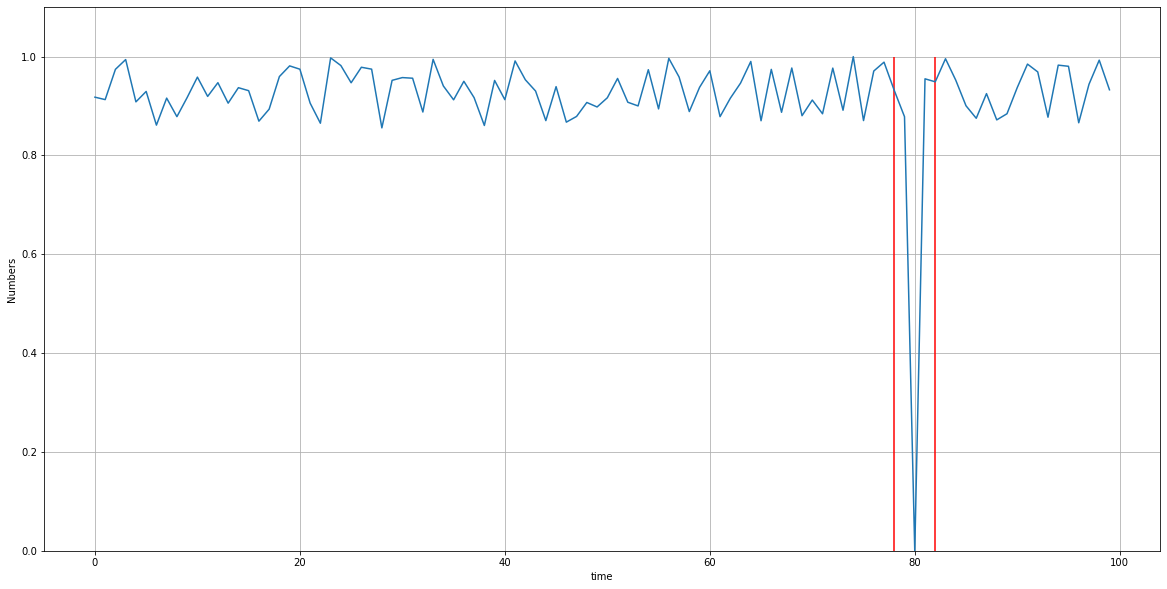

In [33]:
visualize_train_sample(samples)

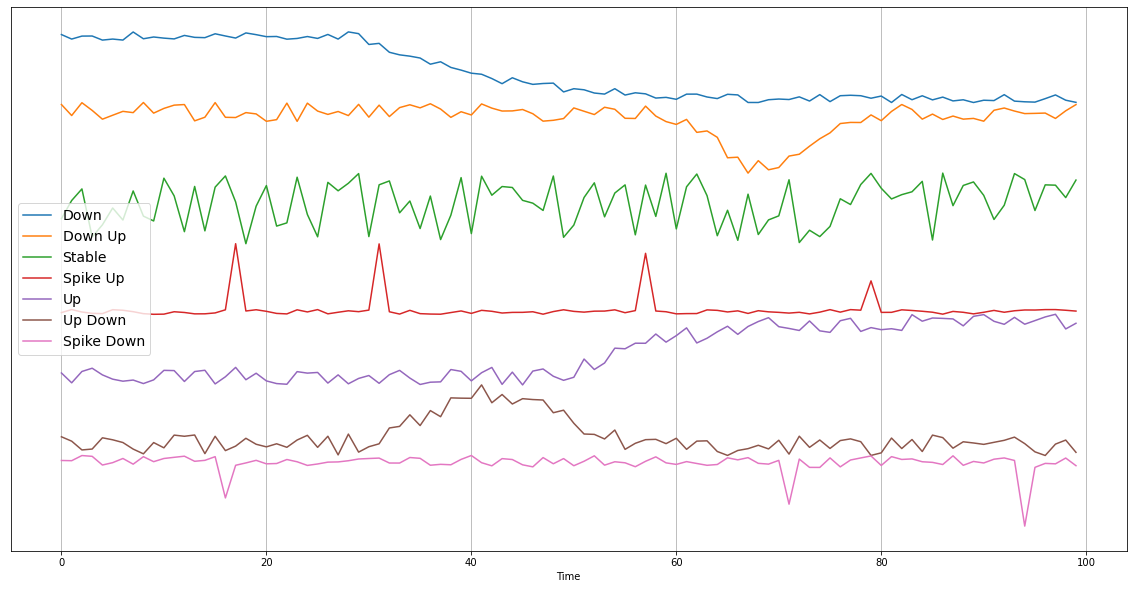

In [30]:
# Now we can pick some samples aligned with patterns to visualize for the paper
visualize_samples([54, 815, 683, 68, 167, 718, 568], samples)

In [34]:
# Now we sample data for testing form real articles
df = pd.read_json('data/dev/cluster_12_cats.json')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207881 entries, 0 to 207880
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        207881 non-null  object
 1   date      207881 non-null  object
 2   title     207881 non-null  object
 3   body      207881 non-null  object
 4   subjects  207881 non-null  object
 5   category  207881 non-null  object
dtypes: object(6)
memory usage: 11.1+ MB


In [36]:
df['category'].unique()

array(['autot', 'musiikki', 'luonto', 'vaalit', 'taudit', 'työllisyys',
       'jääkiekko', 'kulttuuri', 'rikokset', 'koulut', 'tulipalot',
       'ruoat'], dtype=object)

In [37]:
%%time
test_samples, tracker = create_test_samples(df, n_samples=1000, min_doc=8000, max_doc=15000, frac=0.99, change_rates=[0.5, 1])

CPU times: user 5min 59s, sys: 2.36 s, total: 6min 1s
Wall time: 6min 2s


In [38]:
# tracker to track the pivot, pattern, major category for each dataset
tracker.head()

,category,pattern,pivots
0,jääkiekko,down_up,"[64, 79, 94]"
1,autot,spike_up,[48]
2,jääkiekko,down,"[67, 87]"
3,jääkiekko,down,"[10, 75]"
4,koulut,up,"[15, 49]"


In [39]:
test_samples[0].head()

,id,category,time
0,3-7428392,autot,0
1,3-6543729,autot,0
2,3-7460410,autot,0
3,3-7664537,autot,0
4,3-5376997,autot,0


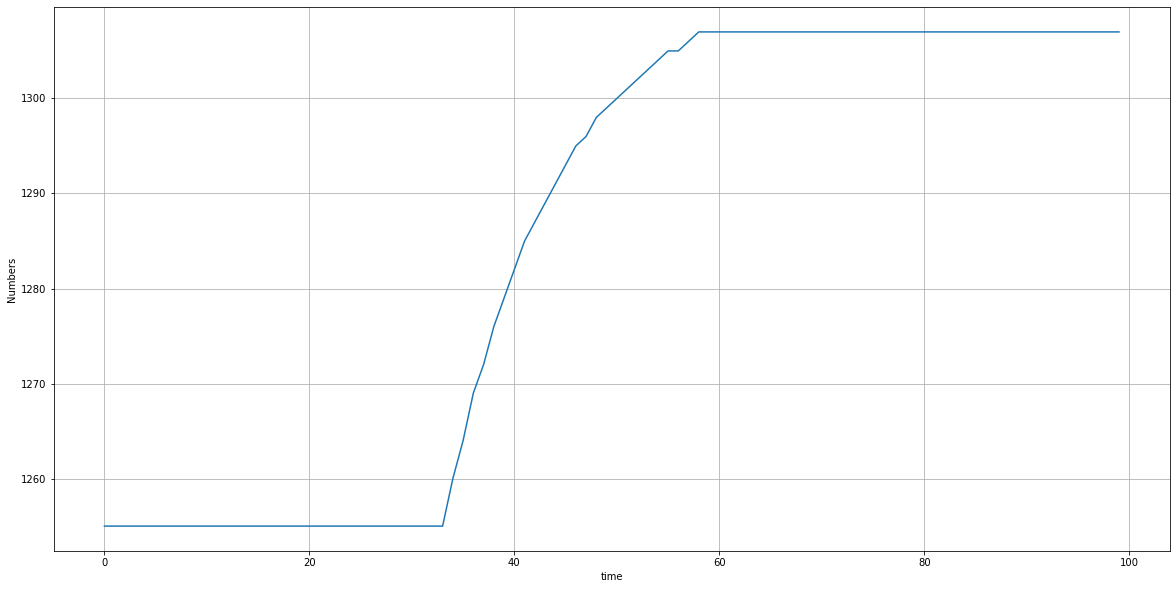

In [40]:
# visualize individual sample
randid = np.random.randint(len(test_samples))
#print(tracker.iloc[randid])
visualize_sample(test_samples[randid])

In [ ]:
# save them to some where
pickle.dump(test_samples, open("data/prod/dataset_2_docs.pkl", "wb"))
tracker.to_pickle('data/prod/dataset_2_pivots.pkl')

In [ ]:
def save_dataset_folder(dataset):
    for i, df in enumerate(dataset):
        df.to_json('data/prod/samples/sample_' + str(i) + '.json')

In [ ]:
# And we also want to save each dataset separatedly to a folder as json
%%time
save_dataset_folder(test_samples)